[PROTECTED$11$](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-schema.ipynb) [PROTECTED$12$](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239426-lesson-1-state-schema)



# 状态模式（State Schema）

## 评审（Review）

In module 1, we laid the foundations! We built up to an agent that can: 

在模块1中，我们奠定了基础！我们逐步构建了一个能够：

* `act` - let the model call specific tools 
* `observe` - pass the tool output back to the model 
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)
* `persist state` - use an in memory checkpointer to support long-running conversations with interruptions
 
And, we showed how to serve it locally in LangGraph Studio or deploy it with LangGraph Cloud. 

*`act` - 让模型调用特定工具* `observe` - 将工具输出传递回模型  
*`reason` - 让模型对工具输出进行推理，以决定下一步操作（例如，调用另一个工具或直接响应）* `persist state` - 使用内存检查点支持带有中断的长时间对话  

并且，我们展示了如何在 LangGraph Studio 中本地部署它，或者通过 LangGraph Cloud 进行部署。

## 目标（Goals）

In this module, we're going to build a deeper understanding of both state and memory.

在本模块中，我们将深入理解状态和内存。

First, let's review a few different ways to define your state schema.

首先，让我们回顾一下定义状态模式的几种不同方法。



In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## 模式（Schema）

When we define a LangGraph `StateGraph`, we use a [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

当我们定义一个 LangGraph `StateGraph` 时，我们使用一个 [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

The state schema represents the structure and types of data that our graph will use.

状态模式表示我们的图形将使用的数据的结构和类型。

All nodes are expected to communicate with that schema.

所有节点都应按照该模式进行通信。

LangGraph offers flexibility in how you define your state schema, accommodating various Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) and validation approaches!

LangGraph 在定义状态模式方面提供了灵活性，能够适应各种 Python [types](https://docs.python.org/3/library/stdtypes.html#type-objects) 和验证方法！

## TypedDict

As we mentioned in Module 1, we can use the `TypedDict` class from python's `typing` module.

正如我们在第1模块中提到的，我们可以使用 Python 的 `typing` 模块中的 `TypedDict` 类。

It allows you to specify keys and their corresponding value types.
 
But, note that these are type hints. 

它允许你指定键及其对应值的类型。

但是，需要注意的是，这些都是类型提示。

They can be used by static type checkers (like [mypy](https://github.com/python/mypy)) or IDEs to catch potential type-related errors before the code is run. 

它们可以被静态类型检查器（如 [mypy](https://github.com/python/mypy)）或集成开发环境（IDE）使用，在代码运行之前捕获潜在的类型相关错误。

But they are not enforced at runtime!

但它们在运行时并未强制执行！



In [2]:
from typing_extensions import TypedDict

class TypedDictState(TypedDict):
    foo: str
    bar: str

For more specific value constraints, you can use things like the `Literal` type hint.

对于更具体的价值约束，您可以使用像 `Literal` 这样的类型提示。

Here, `mood` can only be either "happy" or "sad".

在这里，`mood` 只能是 "happy" 或 "sad"。



In [3]:
from typing import Literal

class TypedDictState(TypedDict):
    name: str
    mood: Literal["happy","sad"]

We can use our defined state class (e.g., here `TypedDictState`) in LangGraph by simply passing it to `StateGraph`.

我们可以通过简单地将其传递给 `StateGraph`，在 LangGraph 中使用我们定义的状态类（例如，此处为 `TypedDictState`）。

And, we can think about each state key as just a "channel" in our graph. 

并且，我们可以将每个状态键视为图中的一个“通道”。

As discussed in Module 1, we overwrite the value of a specified key or "channel" in each node.

如模块1中所述，我们覆盖每个节点中指定键或“通道”的值。



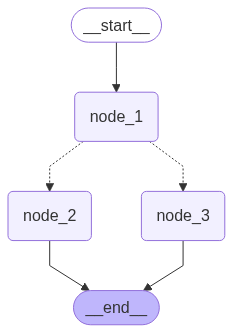

In [4]:
import random
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

def node_1(state):
    print("---Node 1---")
    return {"name": state['name'] + " is ... "}

def node_2(state):
    print("---Node 2---")
    return {"mood": "happy"}

def node_3(state):
    print("---Node 3---")
    return {"mood": "sad"}

def decide_mood(state) -> Literal["node_2", "node_3"]:
        
    # Here, let's just do a 50 / 50 split between nodes 2, 3
    if random.random() < 0.5:

        # 50% of the time, we return Node 2
        return "node_2"
    
    # 50% of the time, we return Node 3
    return "node_3"

# Build graph
builder = StateGraph(TypedDictState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Because our state is a dict, we simply invoke the graph with a dict to set an initial value of the `name` key in our state.

因为我们的状态是一个字典，我们只需用一个字典调用图，以设置状态中 `name` 键的初始值。



In [13]:
graph.invoke({"name":"Lance"})

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}

## 数据类（Dataclass）

Python's [dataclasses](https://docs.python.org/3/library/dataclasses.html) provide [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes).

Python 的 [dataclasses](https://docs.python.org/3/library/dataclasses.html) 提供 [another way to define structured data](https://www.datacamp.com/tutorial/python-data-classes)。

Dataclasses offer a concise syntax for creating classes that are primarily used to store data.

数据类提供了一种简洁的语法，用于创建主要用于存储数据的类。



In [14]:
from dataclasses import dataclass

@dataclass
class DataclassState:
    name: str
    mood: Literal["happy","sad"]

To access the keys of a `dataclass`, we just need to modify the subscripting used in `node_1`: 

要访问 `dataclass` 的键，我们只需修改在 `node_1` 中使用的下标即可：

* We use `state.name` for the `dataclass` state rather than `state["name"]` for the `TypedDict` above

* 我们使用 `state.name` 来表示 `dataclass` 状态，而不是使用 `state["name"]` 来表示上面的 `TypedDict`。

You'll notice something a bit odd: in each node, we still return a dictionary to perform the state updates.
 
This is possible because LangGraph stores each key of your state object separately.

你会注意到一个有点奇怪的地方：在每个节点中，我们仍然返回一个字典来执行状态更新。

这之所以可行，是因为 LangGraph 会单独存储状态对象的每个键。

The object returned by the node only needs to have keys (attributes) that match those in the state!

节点返回的对象只需要具有与状态中的键（属性）匹配的键！

In this case, the `dataclass` has key `name` so we can update it by passing a dict from our node, just as we did when state was a `TypedDict`.

在这种情况下，`dataclass` 拥有键 `name`，因此我们可以通过从节点传递一个字典来更新它，就像在状态为 `TypedDict` 时所做的那样。



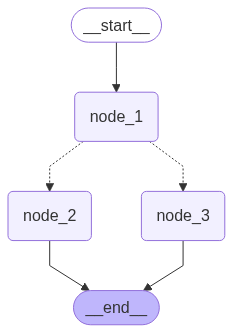

In [15]:
def node_1(state):
    print("---Node 1---")
    return {"name": state.name + " is ... "}

# Build graph
builder = StateGraph(DataclassState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We invoke with a `dataclass` to set the initial values of each key / channel in our state!

我们通过 `dataclass` 来设置状态中每个键/通道的初始值！



In [21]:
graph.invoke(DataclassState(name="Lance",mood="sad"))

---Node 1---
---Node 2---


{'name': 'Lance is ... ', 'mood': 'happy'}

## Pydantic

As mentioned, `TypedDict` and `dataclasses` provide type hints but they don't enforce types at runtime. 
 
This means you could potentially assign invalid values without raising an error!

如前所述，`TypedDict` 和 `dataclasses` 提供类型提示，但它们不会在运行时强制执行类型。

这意味着你可能会在不引发错误的情况下分配无效值！

For example, we can set `mood` to `mad` even though our type hint specifies `mood: list[Literal["happy","sad"]]`.

例如，即使我们的类型提示指定为 `mood: list[Literal["happy","sad"]]`，我们也可以将 `mood` 设置为 `mad`。



In [8]:
dataclass_instance = DataclassState(name="Lance", mood="mad")

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) is a data validation and settings management library using Python type annotations. 

[Pydantic](https://docs.pydantic.dev/latest/api/base_model/) 是一个使用 Python 类型注解的数据验证和设置管理库。

It's particularly well-suited [for defining state schemas in LangGraph](https://langchain-ai.github.io/langgraph/how-tos/state-model/) due to its validation capabilities.

它特别适合 [for defining state schemas in LangGraph](https://langchain-ai.github.io/langgraph/how-tos/state-model/)，因为它的验证功能。

Pydantic can perform validation to check whether data conforms to the specified types and constraints at runtime.

Pydantic 可以在运行时执行验证，以检查数据是否符合指定的类型和约束。



In [ ]:
from pydantic import BaseModel, field_validator, ValidationError

class PydanticState(BaseModel):
    name: str
    mood: str # "happy" or "sad" 

    @field_validator('mood')
    @classmethod
    def validate_mood(cls, value):
        # Ensure the mood is either "happy" or "sad"
        if value not in ["happy", "sad"]:
            raise ValueError("Each mood must be either 'happy' or 'sad'")
        return value

try:
    state = PydanticState(name="John Doe", mood="mad")
except ValidationError as e:
    print("Validation Error:", e)

Validation Error: 1 validation error for PydanticState
mood
  Input should be 'happy' or 'sad' [type=literal_error, input_value='mad', input_type=str]
    For further information visit https://errors.pydantic.dev/2.8/v/literal_error


We can use `PydanticState` in our graph seamlessly. 

我们可以无缝地在图表中使用 `PydanticState`。



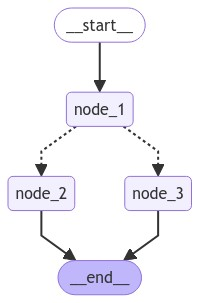

In [ ]:
# Build graph
builder = StateGraph(PydanticState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_conditional_edges("node_1", decide_mood)
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke(PydanticState(name="Lance",mood="sad"))

---Node 1---
---Node 3---


{'name': 'Lance is ... ', 'mood': 'sad'}